# Constructing our Minimum-Covariance Portfolios

We will be constructing our portfolios by selecting the assets which have the lowest correlations between each other. We will rebalance semi-annually based on these selections, and at each rebalance, ensure that our portfolio is split among the two geographies 50/50 

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Risk_analytics

# Data Preprocessing

In [2]:
# Remove 1st line since they are pct changes, therefore have
# NaNs in the first row
rets = pd.read_csv("returns.csv")[1:]
rets.head()

,Date,USA_EWJ,USA_EWT,USA_MCHI,USA_EWY,USA_EWZ,USA_INDA,USA_ACWV,USA_IDV,USA_EWC,...,CAN_HULC.TO,CAN_HMUS.TO,CAN_HSUV.TO,USA_CNY=X,USA_BRL=X,USA_ZAR=X,USA_RUB=X,USA_EUR=X,USA_JPY=X,USA_MXN=X
1,2011-01-04,0.000804,-0.007407,NaN,0.002263,0.004396,NaN,NaN,-0.009259,-0.010412,...,NaN,NaN,NaN,-0.001760,0.019189,0.006326,0.0,0.000134,0.006743,-0.000384
2,2011-01-05,-0.007231,-0.016584,NaN,0.000376,-0.011616,NaN,NaN,-0.002596,0.002023,...,NaN,NaN,NaN,0.002584,0.012754,0.003853,0.0,0.002671,0.004506,-0.004249
3,2011-01-06,0.000000,-0.002108,NaN,-0.006960,-0.010049,NaN,NaN,-0.009891,-0.004847,...,NaN,NaN,NaN,-0.002956,0.004498,0.008670,0.0,0.012522,0.014030,0.003119
4,2011-01-07,0.003777,-0.015632,NaN,0.005493,-0.009119,NaN,NaN,-0.005258,0.000406,...,NaN,NaN,NaN,0.005929,0.006507,0.012983,0.0,0.013551,0.001334,0.000573
5,2011-01-10,0.000000,0.002146,NaN,-0.014883,-0.010071,NaN,NaN,0.000529,-0.003651,...,NaN,NaN,NaN,0.000151,-0.029895,-0.000295,0.0,0.006620,-0.003241,-0.001063


In [3]:
# Reindex to date
rets.index = pd.to_datetime(rets['Date'])
del rets['Date']
rets.head()

,USA_EWJ,USA_EWT,USA_MCHI,USA_EWY,USA_EWZ,USA_INDA,USA_ACWV,USA_IDV,USA_EWC,USA_EWU,...,CAN_HULC.TO,CAN_HMUS.TO,CAN_HSUV.TO,USA_CNY=X,USA_BRL=X,USA_ZAR=X,USA_RUB=X,USA_EUR=X,USA_JPY=X,USA_MXN=X
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-04,0.000804,-0.007407,NaN,0.002263,0.004396,NaN,NaN,-0.009259,-0.010412,0.010462,...,NaN,NaN,NaN,-0.001760,0.019189,0.006326,0.0,0.000134,0.006743,-0.000384
2011-01-05,-0.007231,-0.016584,NaN,0.000376,-0.011616,NaN,NaN,-0.002596,0.002023,-0.002157,...,NaN,NaN,NaN,0.002584,0.012754,0.003853,0.0,0.002671,0.004506,-0.004249
2011-01-06,0.000000,-0.002108,NaN,-0.006960,-0.010049,NaN,NaN,-0.009891,-0.004847,-0.008647,...,NaN,NaN,NaN,-0.002956,0.004498,0.008670,0.0,0.012522,0.014030,0.003119
2011-01-07,0.003777,-0.015632,NaN,0.005493,-0.009119,NaN,NaN,-0.005258,0.000406,-0.003925,...,NaN,NaN,NaN,0.005929,0.006507,0.012983,0.0,0.013551,0.001334,0.000573
2011-01-10,0.000000,0.002146,NaN,-0.014883,-0.010071,NaN,NaN,0.000529,-0.003651,0.001751,...,NaN,NaN,NaN,0.000151,-0.029895,-0.000295,0.0,0.006620,-0.003241,-0.001063


In [4]:
# Delete any outliers
rets[rets > 1] = 0
rets[rets < -1] = 0

In [5]:
sum(rets["USA_RUB=X"] > 100)

0

In [6]:
rets.index

DatetimeIndex(['2011-01-04', '2011-01-05', '2011-01-06', '2011-01-07',
               '2011-01-10', '2011-01-11', '2011-01-12', '2011-01-13',
               '2011-01-14', '2011-01-17',
               ...
               '2021-06-22', '2021-06-23', '2021-06-24', '2021-06-25',
               '2021-06-28', '2021-06-29', '2021-06-30', '2021-07-01',
               '2021-07-02', '2021-07-05'],
              dtype='datetime64[ns]', name='Date', length=2740, freq=None)

In [7]:
# read the risk free rate
riskfree = pd.read_csv("3mTbill.csv")
riskfree['Date'] = pd.to_datetime(riskfree['Date'])
riskfree.head()

,Date,RFR
0,2010-01-01,0.061
1,2010-01-04,0.060
2,2010-01-05,0.066
3,2010-01-06,0.054
4,2010-01-07,0.049


In [8]:
riskfree

,Date,RFR
0,2010-01-01,0.061
1,2010-01-04,0.060
2,2010-01-05,0.066
3,2010-01-06,0.054
4,2010-01-07,0.049
...,...,...
3001,2021-07-05,0.044
3002,2021-07-06,0.047
3003,2021-07-07,0.048
3004,2021-07-08,0.048


In [9]:
# match the date
riskfree = riskfree[riskfree['Date'].isin(rets.index.values)].set_index('Date')
riskfree.head()

,RFR
Date,
2011-01-04,0.140
2011-01-05,0.140
2011-01-06,0.145
2011-01-07,0.140
2011-01-10,0.140


In [10]:
# daily risk free
riskfree = (1 + riskfree).pow(1/252) - 1
riskfree.head()

,RFR
Date,
2011-01-04,0.000520
2011-01-05,0.000520
2011-01-06,0.000537
2011-01-07,0.000520
2011-01-10,0.000520


In [11]:
len(riskfree.index) == len(rets.index)

True

In [12]:
# Create a list of semiannual dates to split on
dates_to_split = pd.date_range(rets.index[0], rets.index[-1], freq='6M')
dates_to_split

DatetimeIndex(['2011-01-31', '2011-07-31', '2012-01-31', '2012-07-31',
               '2013-01-31', '2013-07-31', '2014-01-31', '2014-07-31',
               '2015-01-31', '2015-07-31', '2016-01-31', '2016-07-31',
               '2017-01-31', '2017-07-31', '2018-01-31', '2018-07-31',
               '2019-01-31', '2019-07-31', '2020-01-31', '2020-07-31',
               '2021-01-31'],
              dtype='datetime64[ns]', freq='6M')

In [13]:
# Split on these dates
semiannual = {}

for i in range(len(dates_to_split)-1):
    #print(dates_to_split[i+1])
    semiannual[i] = rets[dates_to_split[i]:dates_to_split[i+1]]

In [14]:
# Sanity check
print(semiannual[0].index[0],semiannual[0].index[-1])

2011-01-31 00:00:00 2011-07-29 00:00:00


In [15]:
# Sanity check
print(semiannual[1].index[0],semiannual[1].index[-1])

2011-08-01 00:00:00 2012-01-31 00:00:00


In [16]:
# Sanity check
print(semiannual[19].index[0],semiannual[19].index[-1])

2020-07-31 00:00:00 2021-01-29 00:00:00


# Lowest correlation Search

In [17]:
# For each group of 6mo, find the assets with lowest avg correlation
corrs = semiannual[10].corr().abs().mean(axis=1)
corrs

USA_EWJ      0.435156
USA_EWT      0.511699
USA_MCHI     0.528725
USA_EWY      0.541586
USA_EWZ      0.432182
               ...   
USA_ZAR=X    0.118197
USA_RUB=X    0.084428
USA_EUR=X    0.151444
USA_JPY=X    0.082320
USA_MXN=X    0.462142
Length: 128, dtype: float64

In [18]:
# Sort those values to see which ones have lowest correlation
corrs.sort_values(axis=0)[:30]

CAN_XFR.TO    0.075507
CAN_CMR.TO    0.081464
USA_JPY=X     0.082320
USA_RUB=X     0.084428
USA_BRL=X     0.085703
CAN_HXQ.TO    0.097759
CAN_HHF.TO    0.113232
CAN_CBO.TO    0.113303
USA_ZAR=X     0.118197
USA_CNY=X     0.120320
CAN_HUZ.TO    0.144101
USA_EUR=X     0.151444
CAN_XSC.TO    0.154957
CAN_SVR.TO    0.162192
CAN_HXF.TO    0.165272
CAN_XGD.TO    0.181217
CAN_HUN.TO    0.185430
CAN_XIG.TO    0.186638
CAN_CVD.TO    0.190808
USA_KSA       0.198407
CAN_CBH.TO    0.199100
CAN_HUG.TO    0.208522
CAN_HTB.TO    0.237717
CAN_XUU.TO    0.248717
CAN_CGL.TO    0.253634
CAN_CLF.TO    0.280254
CAN_CGR.TO    0.283629
CAN_CLG.TO    0.284980
CAN_HXE.TO    0.285884
USA_QAT       0.286492
dtype: float64

In [19]:
# First 15 CAN values
[x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:15]

['CAN_XFR.TO',
 'CAN_CMR.TO',
 'CAN_HXQ.TO',
 'CAN_HHF.TO',
 'CAN_CBO.TO',
 'CAN_HUZ.TO',
 'CAN_XSC.TO',
 'CAN_SVR.TO',
 'CAN_HXF.TO',
 'CAN_XGD.TO',
 'CAN_HUN.TO',
 'CAN_XIG.TO',
 'CAN_CVD.TO',
 'CAN_CBH.TO',
 'CAN_HUG.TO']

In [20]:
# Loop through each semiannual period, save the 10, 15 or 30 Canadian and USA assets with the
# lowest average correlation
top10 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top10[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:10]
    top10[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:10]

top15 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top15[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:15]
    top15[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:15]

top30 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top30[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:30]
    top30[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:30]

In [21]:
# We only need the index
top30[1]

['USA_JPY=X',
 'USA_ZAR=X',
 'USA_RUB=X',
 'USA_BRL=X',
 'USA_EUR=X',
 'USA_CNY=X',
 'USA_EPU',
 'USA_TUR',
 'USA_EPHE',
 'USA_ECH',
 'USA_EWJ',
 'USA_THD',
 'USA_EIRL',
 'USA_EIDO',
 'USA_MCHI',
 'USA_EIS',
 'USA_EWZ',
 'USA_EWH',
 'USA_ERUS',
 'USA_MXN=X',
 'USA_ENZL',
 'USA_EWL',
 'USA_EWT',
 'USA_EWW',
 'USA_EWY',
 'USA_EWM',
 'USA_EWP',
 'USA_EWS',
 'USA_EPOL',
 'USA_EZA',
 'CAN_CMR.TO',
 'CAN_HUN.TO',
 'CAN_CVD.TO',
 'CAN_CGL.TO',
 'CAN_HUG.TO',
 'CAN_XIG.TO',
 'CAN_CGR.TO',
 'CAN_DLR.TO',
 'CAN_XGD.TO',
 'CAN_HUC.TO',
 'CAN_CBO.TO',
 'CAN_CHB.TO',
 'CAN_HUZ.TO',
 'CAN_SVR.TO',
 'CAN_CWW.TO',
 'CAN_CLF.TO',
 'CAN_XPF.TO',
 'CAN_HXS.TO',
 'CAN_COW.TO',
 'CAN_XHY.TO',
 'CAN_HXT.TO',
 'CAN_XUU.TO',
 'CAN_XDG.TO',
 'CAN_XBM.TO',
 'CAN_XDGH.TO',
 'CAN_XGGB.TO',
 'CAN_CLG.TO',
 'CAN_CBH.TO',
 'CAN_XSE.TO',
 'CAN_XFR.TO']

# Equally-weighted portfolio

In [22]:
# Let's create a one-period example before looping through them all, start
# with 100k capital
capital = 100000

In [23]:
# Use previous period's lowest corrs to construct portfolio
# for current period
returns = semiannual[1][top30[1]]
returns

,USA_JPY=X,USA_ZAR=X,USA_RUB=X,USA_BRL=X,USA_EUR=X,USA_CNY=X,USA_EPU,USA_TUR,USA_EPHE,USA_ECH,...,CAN_HXT.TO,CAN_XUU.TO,CAN_XDG.TO,CAN_XBM.TO,CAN_XDGH.TO,CAN_XGGB.TO,CAN_CLG.TO,CAN_CBH.TO,CAN_XSE.TO,CAN_XFR.TO
Date,,,,,,,,,,,,,,,,,,,,,
2011-08-01,-0.006651,-0.007357,0.002785,-0.010430,-0.002150,-0.002219,0.005180,-0.006188,0.009129,0.020165,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-02,0.003199,0.008252,0.004507,0.007307,0.007182,-0.000482,-0.027197,-0.030212,-0.015625,-0.027369,...,-0.017975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-03,-0.001614,0.010074,0.003179,0.003531,0.006275,0.000560,-0.012655,0.021165,0.000835,-0.013722,...,0.006744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-04,-0.002884,-0.010607,-0.000783,-0.000192,-0.012613,-0.000342,-0.054844,-0.081509,-0.035476,-0.054244,...,-0.031579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-05,0.028245,0.032729,0.014975,0.008829,0.020382,0.000124,-0.005046,-0.038793,0.000000,-0.021043,...,-0.016798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-01-25,0.008922,0.002244,-0.002271,0.003653,-0.001042,0.001267,0.022340,0.020039,-0.001661,-0.003078,...,0.011605,NaN,NaN,0.026786,NaN,NaN,NaN,NaN,NaN,-0.001115
2012-01-26,0.001068,-0.009787,-0.010080,0.000910,-0.005086,-0.001345,0.015814,0.019918,-0.011231,0.004245,...,-0.008604,NaN,NaN,-0.003953,NaN,NaN,NaN,NaN,NaN,0.000000
2012-01-27,-0.003986,-0.006987,-0.004352,0.052557,0.001180,0.003247,0.001981,0.027822,0.020194,0.005573,...,0.002893,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000


In [24]:
# Save the sum of the dollar returns, add to capital
capital += returns.cumsum().iloc[-1,:].sum()
capital

99998.90786344971

In [25]:
returns.columns

Index(['USA_JPY=X', 'USA_ZAR=X', 'USA_RUB=X', 'USA_BRL=X', 'USA_EUR=X',
       'USA_CNY=X', 'USA_EPU', 'USA_TUR', 'USA_EPHE', 'USA_ECH', 'USA_EWJ',
       'USA_THD', 'USA_EIRL', 'USA_EIDO', 'USA_MCHI', 'USA_EIS', 'USA_EWZ',
       'USA_EWH', 'USA_ERUS', 'USA_MXN=X', 'USA_ENZL', 'USA_EWL', 'USA_EWT',
       'USA_EWW', 'USA_EWY', 'USA_EWM', 'USA_EWP', 'USA_EWS', 'USA_EPOL',
       'USA_EZA', 'CAN_CMR.TO', 'CAN_HUN.TO', 'CAN_CVD.TO', 'CAN_CGL.TO',
       'CAN_HUG.TO', 'CAN_XIG.TO', 'CAN_CGR.TO', 'CAN_DLR.TO', 'CAN_XGD.TO',
       'CAN_HUC.TO', 'CAN_CBO.TO', 'CAN_CHB.TO', 'CAN_HUZ.TO', 'CAN_SVR.TO',
       'CAN_CWW.TO', 'CAN_CLF.TO', 'CAN_XPF.TO', 'CAN_HXS.TO', 'CAN_COW.TO',
       'CAN_XHY.TO', 'CAN_HXT.TO', 'CAN_XUU.TO', 'CAN_XDG.TO', 'CAN_XBM.TO',
       'CAN_XDGH.TO', 'CAN_XGGB.TO', 'CAN_CLG.TO', 'CAN_CBH.TO', 'CAN_XSE.TO',
       'CAN_XFR.TO'],
      dtype='object')

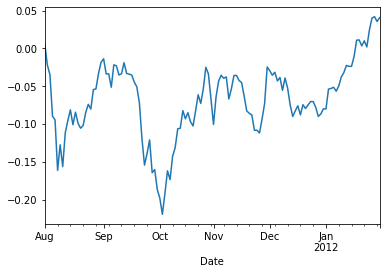

In [26]:
# Sanity check to make sure calculation is correct
returns['USA_EPU'].cumsum().plot()

In [27]:
# Reallocate capital and rebalance
position_size = capital / 60
position_size

1666.6484643908286

In [28]:
# Use new allocations to calculate next period
returns2 = semiannual[2][top30[2]] * position_size
returns2

,USA_CNY=X,USA_JPY=X,USA_RUB=X,USA_BRL=X,USA_ZAR=X,USA_EUR=X,USA_KXI,USA_ACWV,USA_MXN=X,USA_EPHE,...,CAN_XHY.TO,CAN_HXT.TO,CAN_XBM.TO,CAN_XUU.TO,CAN_XDG.TO,CAN_XDGH.TO,CAN_XGGB.TO,CAN_CLG.TO,CAN_CBH.TO,CAN_XSE.TO
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-31,-2.740851,-8.079983,13.083646,7.959253,18.251904,8.805434,-2.534827,0.790818,11.019015,25.986512,...,2.763928,-1.605634,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-01,-1.319888,-1.964358,-16.573130,-1.431583,-7.749675,7.883241,16.501470,15.413633,-21.535632,42.184878,...,2.759352,6.428731,10.700793,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-02,-0.475536,-1.770008,4.270869,-12.513236,-27.763928,-11.769193,-1.885349,1.566399,-12.163995,28.328303,...,1.377395,4.803022,14.619723,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-03,-0.687082,-0.196877,1.847824,-13.089114,-5.307521,4.170462,14.470711,7.824641,-17.285152,8.621739,...,2.752516,4.789220,18.445121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-06,0.105748,8.116652,0.817889,-2.716149,-21.123333,1.313701,-3.742474,-12.460923,0.658609,-3.958785,...,0.000000,-3.183665,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-07-25,0.391471,-4.341616,15.288337,7.447702,12.242592,8.688880,0.000000,7.577397,-13.312277,4.907320,...,-4.012797,3.432850,-3.638970,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
2012-07-26,0.260919,-0.085352,-13.387345,-10.429284,-22.016880,-10.855026,40.103360,20.743531,-24.155036,23.241336,...,16.089929,22.267657,12.764266,NaN,NaN,NaN,NaN,-4.365811,-2.276842,NaN
2012-07-27,-1.173953,4.715943,-18.977759,-10.330974,-30.720625,-19.019662,24.763609,18.253414,-21.301922,20.508884,...,7.968040,16.903128,54.288224,NaN,NaN,NaN,NaN,-6.565916,-7.979849,NaN


In [29]:
# Concatenate to get continuous stream
pd.concat([returns, returns2])

,USA_JPY=X,USA_ZAR=X,USA_RUB=X,USA_BRL=X,USA_EUR=X,USA_CNY=X,USA_EPU,USA_TUR,USA_EPHE,USA_ECH,...,CAN_XDGH.TO,CAN_XGGB.TO,CAN_CLG.TO,CAN_CBH.TO,CAN_XSE.TO,CAN_XFR.TO,USA_KXI,USA_ACWV,USA_IXJ,USA_EWI
Date,,,,,,,,,,,,,,,,,,,,,
2011-08-01,-0.006651,-0.007357,0.002785,-0.010430,-0.002150,-0.002219,0.005180,-0.006188,0.009129,0.020165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-02,0.003199,0.008252,0.004507,0.007307,0.007182,-0.000482,-0.027197,-0.030212,-0.015625,-0.027369,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-03,-0.001614,0.010074,0.003179,0.003531,0.006275,0.000560,-0.012655,0.021165,0.000835,-0.013722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-04,-0.002884,-0.010607,-0.000783,-0.000192,-0.012613,-0.000342,-0.054844,-0.081509,-0.035476,-0.054244,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-05,0.028245,0.032729,0.014975,0.008829,0.020382,0.000124,-0.005046,-0.038793,0.000000,-0.021043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-07-25,-4.341616,12.242592,15.288337,7.447702,8.688880,0.391471,-5.475846,23.005254,4.907320,-3.213126,...,NaN,NaN,0.000000,0.000000,NaN,0.9208,0.000000,7.577397,9.215276,37.904479
2012-07-26,-0.085352,-22.016880,-13.387345,-10.429284,-10.855026,0.260919,17.980025,66.860442,23.241336,-5.472865,...,NaN,NaN,-4.365811,-2.276842,NaN,0.0000,40.103360,20.743531,24.220736,108.938613
2012-07-27,4.715943,-30.720625,-18.977759,-10.330974,-19.019662,-1.173953,24.211614,38.958590,20.508884,19.702627,...,NaN,NaN,-6.565916,-7.979849,NaN,0.0000,24.763609,18.253414,30.326163,80.117194


# Portfolio weight optimization - Risk Parity and Sharpe Ratio Maximization

In [30]:
from scipy.optimize import minimize
import math

Risk Parity

In [31]:
# Risk Parity:
def Risk_parity(portfolio, kappa=5):
    """
    Implement the risk parity optimization.
    """
    # min   (1/2) * (x' * Q * x) - kappa * sum_{i=1}^n ln(x_i)
    # s.t.  x >= 0
    
    _cov = portfolio.cov()
    # number of assets
    n = _cov.shape[0]

    # parameters for nonlinear program
    eps = 1e-3

    def safe_log(x):
        if x > eps:
            return math.log(x)
        logeps = math.log(eps)
        a = 1 / (3 * eps * (3 * logeps * eps) ** 2)
        b = eps * (1 - 3 * logeps)
        return a * (x - b) ** 3

    def f(x, _cov, kappa):
        func = 0.5 * x.T.dot(_cov.dot(x))

        for i in range(n):
            func = func - kappa * safe_log(x[i])

        return func

    xinit = np.repeat(1 / n, n)
    lb = 0
    ub = 1
    bnds = tuple([(lb, ub) for x in xinit])

    res = minimize(f, args=(_cov, kappa), method='trust-constr',
                   x0=xinit, bounds=bnds, tol=10 ** -3)

    return res.x / np.sum(res.x)

Maximum Sharpe Ratio

In [32]:
# Maximum Sharpe Ratio Portfolio

def sharpe_ratio_calculation(w,_return,_cov):
    return - _return.mul(w,axis=1).sum(axis=1).cumsum()[-1]/np.sqrt(np.dot(w.T,np.dot(_cov,w)))

def sharpe_ratio_maximization(portfolio):
    _return = portfolio
    _cov = portfolio.cov()
    n = _cov.shape[0]
    constraints = [{'type':'eq','fun': lambda x: sum(x)-1}]
    outcome = minimize(sharpe_ratio_calculation,x0 = np.repeat(1/n,n),args = (_return,_cov), 
                       constraints = constraints, bounds= tuple((0,1) for x in range(n)))
    return outcome.x

In [33]:
riskfree

,RFR
Date,
2011-01-04,0.000520
2011-01-05,0.000520
2011-01-06,0.000537
2011-01-07,0.000520
2011-01-10,0.000520
...,...
2021-06-29,0.000178
2021-06-30,0.000167
2021-07-01,0.000178


In [37]:
i =5
cutoff = 10
top_cor = top30
_return = usd = semiannual[i-1][top_cor[i][:cutoff]].subtract(riskfree['RFR'], axis=0)[semiannual[i-1][top_cor[i][:cutoff]].index[0]:semiannual[i-1][top_cor[i][:cutoff]].index[-1]]
_weight = Risk_parity(_return)
_weight

array([0.10000005, 0.10000002, 0.10000004, 0.10000001, 0.10000003,
       0.10000003, 0.09999983, 0.09999993, 0.10000009, 0.09999997])

In [38]:
_risk = Risk_analytics.risk(_return,_weight,30)
_risk.sharpe_ratio()

11.441065939628244

In [40]:
import warnings
warnings.filterwarnings('ignore')
import Risk_analytics

In [49]:
# function to calculate the rebalanced portfolio 

def portfolio_simulator(initial_capital, semiannual, riskfree, top_cor, cutoff, optimization_type):
    
    # 50/50 for US and CA ETF
    USDcapital = initial_capital/2
    CADcapital = initial_capital/2
    capital = USDcapital + CADcapital
    
    # dataframes to store the portfolio info
    dollar_full_portfolio = pd.DataFrame()
    pct_full_portfolio = pd.DataFrame()
    USD_PnL = {}
    CAD_PnL= {}
    PnL = {}
    
    USD_risk_profile = pd.DataFrame()
    CAD_risk_profile = pd.DataFrame()
    overall_risk_profile = pd.DataFrame()

    for i in range(2,len(semiannual.keys())):

        # Calculate the optimal weights

        # First period correltion is for next period.
        usd = semiannual[i-1][top_cor[i][:cutoff]].subtract(riskfree['RFR'], axis=0)[semiannual[i-1][top_cor[i][:cutoff]].index[0]:semiannual[i-1][top_cor[i][:cutoff]].index[-1]]
        cad = semiannual[i-1][top_cor[i][cutoff:]].subtract(riskfree['RFR'], axis=0)[semiannual[i-1][top_cor[i][cutoff:]].index[0]:semiannual[i-1][top_cor[i][cutoff:]].index[-1]]
        
        # fit optimization based on specified type
        if optimization_type == 'Risk parity':
            usdweights = Risk_parity(usd)
            cadweights = Risk_parity(cad)
        elif optimization_type == 'Sharpe ratio maximization':
            usdweights = sharpe_ratio_maximization(usd)
            cadweights = sharpe_ratio_maximization(cad)
        else:
            raise Exception('Type not available.')

        # Calculate the returns
        usdreturns = semiannual[i][top_cor[i][:cutoff]]
        cadreturns = semiannual[i][top_cor[i][cutoff:]]

        usd_portfolio_return = usdreturns.mul(usdweights,axis=1)
        cad_portfolio_return = cadreturns.mul(cadweights,axis=1)

        # Remove an outlier
        usd_portfolio_return[usd_portfolio_return.values > 100] = 0
        cad_portfolio_return[cad_portfolio_return.values > 100] = 0

        # Portfolio Returns
        portfolio_return = pd.concat([usd_portfolio_return,cad_portfolio_return], axis=1, ignore_index = True)

        pct_full_portfolio = pd.concat([pct_full_portfolio, portfolio_return])
        dollar_full_portfolio = pd.concat([dollar_full_portfolio, portfolio_return])

        #PnL calculation
        USD_PnL[i] = usd_portfolio_return.sum(axis=1)*USDcapital
        CAD_PnL[i] = cad_portfolio_return.sum(axis=1)*CADcapital
        PnL[i] = USD_PnL[i] + CAD_PnL[i]
        capital += (PnL[i].cumsum()[-1] - PnL[i].cumsum()[0])
        USDcapital = capital/2
        CADcapital = capital/2
        
        # Risk calculation
        _USDrisk = Risk_analytics.risk(usdreturns,usdweights,cutoff)
        _CADrisk = Risk_analytics.risk(cadreturns,cadweights,cutoff)
        _USDVaR95,_USDCVaR95 = _USDrisk.hist_var(5)
        _CADVaR95,_CADCVaR95 = _CADrisk.hist_var(5)
        _USDVaR99,_USDCVaR99 = _USDrisk.hist_var(1)
        _CADVaR99,_CADCVaR99 = _CADrisk.hist_var(1)
        _USDVaR95*= USDcapital
        _USDVaR99*= USDcapital
        _USDCVaR95*= USDcapital
        _USDCVaR99*= USDcapital
        _CADVaR95*= CADcapital
        _CADVaR99*= CADcapital
        _CADCVaR95*= CADcapital
        _CADCVaR99*= CADcapital
        
        
        _USDriskprofile = {'Period':i,'VaR 95%':[_USDVaR95],'VaR 99%':[_USDVaR99],
                       'CVaR 95%':[_USDCVaR95],'CVaR 99%':[_USDCVaR99],
                       'Sharpe Ratio':[_USDrisk.sharpe_ratio()],'Max_drawdown':[_USDrisk.max_drawdown()]}
        
        _CADriskprofile = {'Period':i,'VaR 95%':[_CADVaR95],'VaR 99%':[_CADVaR99],
                       'CVaR 95%':[_CADCVaR95],'CVaR 99%':[_CADCVaR99],
                       'Sharpe Ratio':[_CADrisk.sharpe_ratio()],'Max_drawdown':[_CADrisk.max_drawdown()]}
        
        _overallriskprofile = {'Period':i,'VaR 95%':[_USDVaR95+_CADVaR95],
                               'VaR 99%':[_USDVaR99+_CADVaR99],
                               'CVaR 95%':[_USDCVaR95+_CADCVaR95],
                               'CVaR 99%':[_USDCVaR99+_CADCVaR99]}
        
        _USDriskprofile = pd.DataFrame.from_dict(_USDriskprofile)
        _CADriskprofile = pd.DataFrame.from_dict(_CADriskprofile)
        _overall_risk_profile = pd.DataFrame.from_dict(_overallriskprofile)
        USD_risk_profile = pd.concat([USD_risk_profile,_USDriskprofile])
        CAD_risk_profile = pd.concat([CAD_risk_profile,_CADriskprofile])
        overall_risk_profile = pd.concat([overall_risk_profile,_overall_risk_profile])


        # Note: we don't need to do rebalancing operation. Just reallocate the capital is enough.
    USD_risk_profile.set_index('Period',inplace= True)
    CAD_risk_profile.set_index('Period',inplace= True)
    overall_risk_profile.set_index('Period',inplace= True)

    return pct_full_portfolio, dollar_full_portfolio, PnL,USD_risk_profile,CAD_risk_profile,overall_risk_profile

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
def max_drawdown(ts):
    previous_peaks = ts.cummax()
    drawdown = (ts-previous_peaks)/previous_peaks
    return f'{drawdown.min()*100}%'

# Optimized weight for cutoff 30-ETFs

In [52]:
pct_full_portfolio_rp, dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp = portfolio_simulator(100000, semiannual, riskfree, top30, 30, 'Risk parity')
pct_full_portfolio_sr, dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr = portfolio_simulator(100000, semiannual, riskfree, top30, 30, 'Sharpe ratio maximization')

Max drawdown: -252.3651765051448%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-973.102262,-1520.411229,-1253.779556,-1531.222170
3,-547.302672,-954.881775,-771.397199,-991.356310
4,-907.398918,-1965.102654,-1509.833967,-2410.378726
5,-1019.252156,-1533.409513,-1293.747747,-1661.545351
6,-692.273627,-1124.437750,-960.499252,-1161.385846
7,-943.390309,-1242.239652,-1148.582589,-1394.289420
8,-839.899753,-1231.459814,-1074.282966,-1369.665555
9,-1174.691894,-2543.318755,-1814.040207,-2756.991581
10,-984.266111,-1703.622247,-1541.359436,-2398.195491


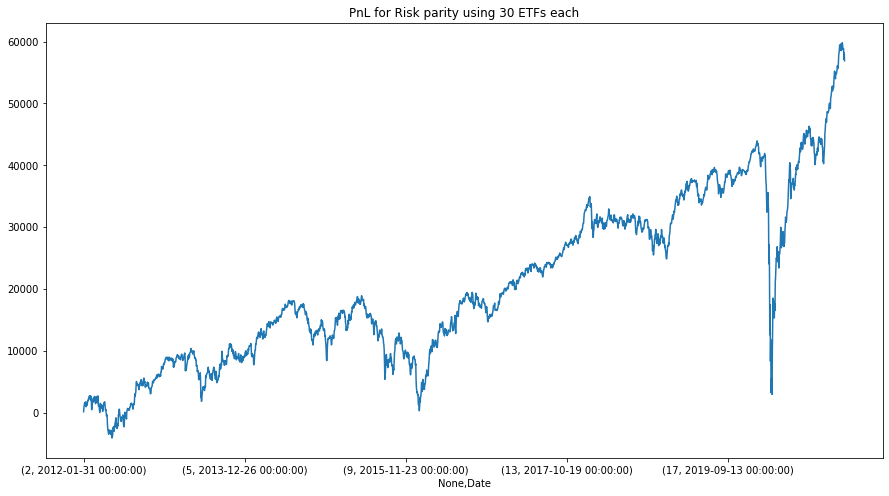

In [56]:
pd.concat(PnL_rp).cumsum().plot(figsize=(15,8))
plt.title('PnL for Risk parity using 30 ETFs each')
md = max_drawdown
print(f'Max drawdown: {max_drawdown(pd.concat(PnL_rp).cumsum())}')
overallrisk_rp

Max drawdown: -254.94763904365615%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-326.696992,-433.850041,-383.524500,-471.018262
3,-461.109829,-565.882115,-553.830424,-692.140471
4,-1152.072717,-1830.377898,-1505.926540,-2112.089019
5,-755.571201,-1421.225608,-1107.619301,-1560.063503
6,-502.632513,-698.851747,-609.400214,-769.656623
7,-739.464039,-1371.381570,-1057.404151,-1431.318577
8,-537.316953,-833.001266,-694.869109,-870.477688
9,-1241.780935,-2549.683804,-1846.478946,-2905.026370
10,-1243.704441,-1683.331058,-1509.205724,-1743.318372


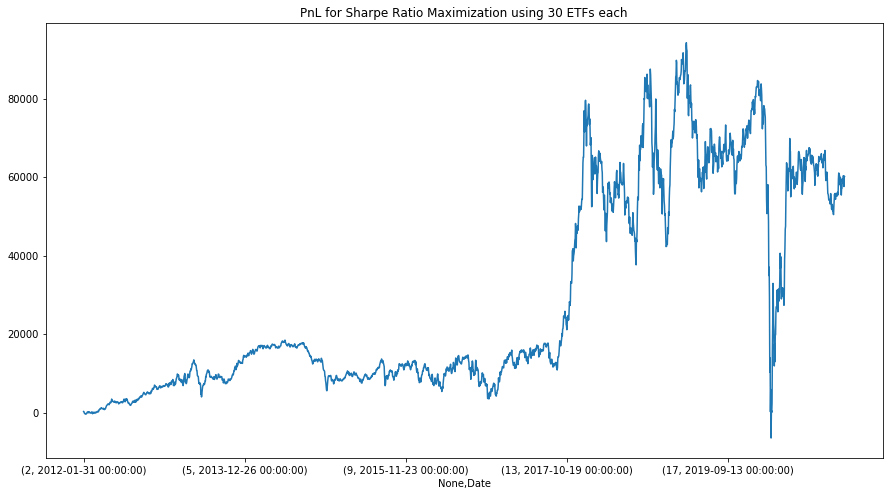

In [71]:
pd.concat(PnL_sr).cumsum().plot(figsize=(15,8))
plt.title('PnL for Sharpe Ratio Maximization using 30 ETFs each')
md = max_drawdown
print(f'Max drawdown: {max_drawdown(pd.concat(PnL_sr).cumsum())}')
overallrisk_sr

Text(0.5, 1.0, 'For Risk parity using 30 ETFs each')

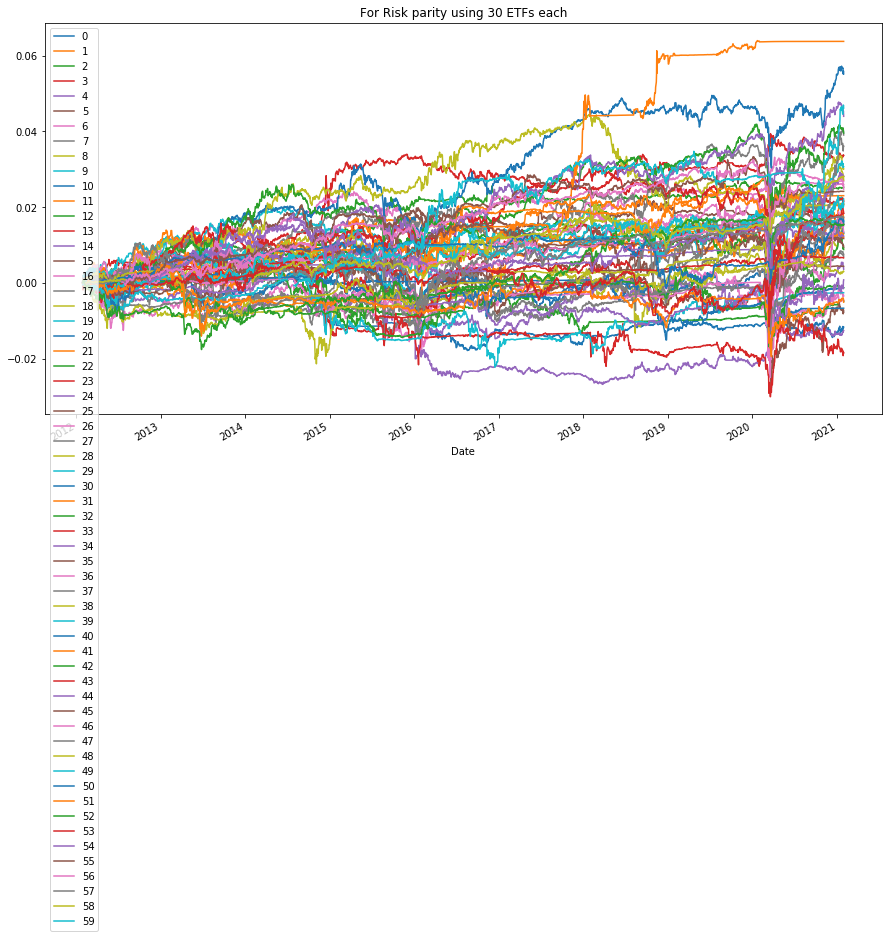

In [58]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.title('For Risk parity using 30 ETFs each')

Text(0.5, 1.0, 'For Sharpe Ratio Maximization using 30 ETFs each')

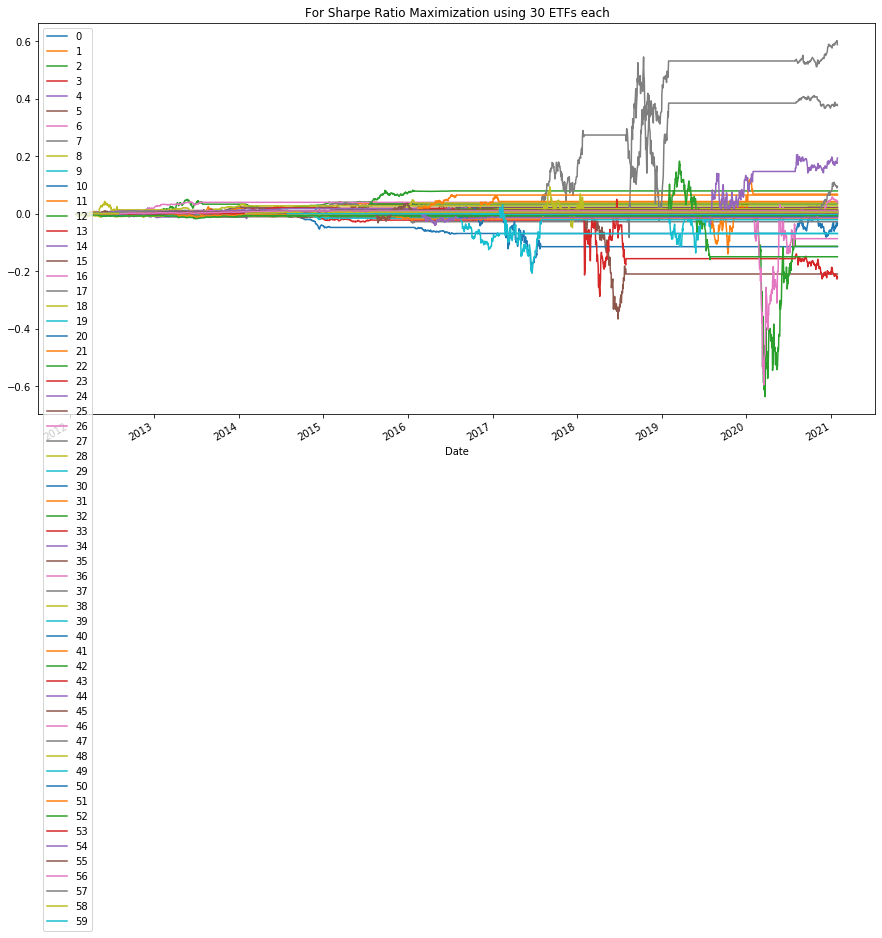

In [59]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.title('For Sharpe Ratio Maximization using 30 ETFs each')

# Optimized weight for cutoff 15-ETFs

In [62]:
pct_full_portfolio_rp, dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp = portfolio_simulator(100000, semiannual, riskfree, top15, 15, 'Risk parity')
pct_full_portfolio_sr, dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr = portfolio_simulator(100000, semiannual, riskfree, top15, 15, 'Sharpe ratio maximization')

Max drawdown: -210.91278398160648%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-842.725782,-1302.619011,-1100.068127,-1407.249686
3,-537.229660,-784.347486,-711.800829,-892.612365
4,-691.906420,-1531.032459,-1070.767284,-1626.969517
5,-678.589351,-1021.616397,-876.769250,-1121.366381
6,-432.638994,-517.747498,-516.352746,-674.265285
7,-986.340923,-1470.361530,-1299.694601,-1604.286810
8,-810.171907,-1170.562479,-1068.761383,-1240.154276
9,-1010.309926,-2212.994095,-1690.232478,-3217.353169
10,-797.719667,-1237.204151,-1139.504222,-1753.380376


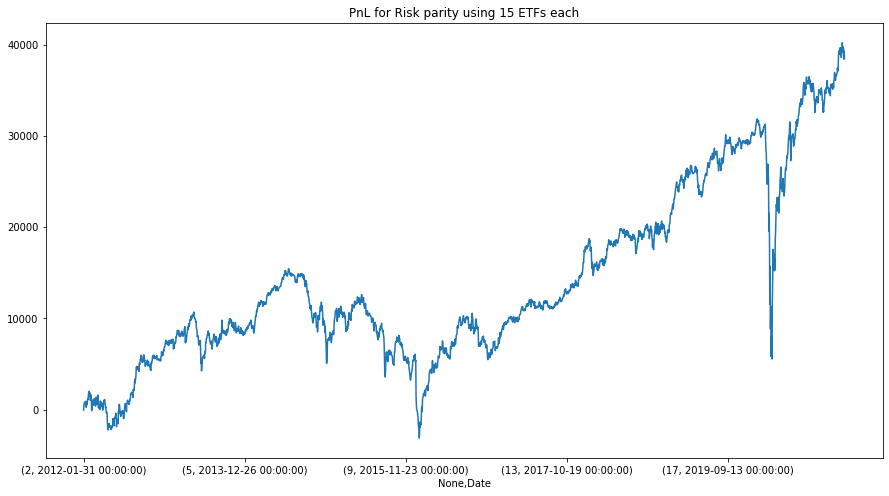

In [63]:
pd.concat(PnL_rp).cumsum().plot(figsize=(15,8))
plt.title('PnL for Risk parity using 15 ETFs each')
md = max_drawdown
print(f'Max drawdown: {max_drawdown(pd.concat(PnL_rp).cumsum())}')
overallrisk_rp

Max drawdown: -254.94763904365615%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-326.696992,-433.850041,-383.524500,-471.018262
3,-461.109829,-565.882115,-553.830424,-692.140471
4,-1152.072717,-1830.377898,-1505.926540,-2112.089019
5,-755.571201,-1421.225608,-1107.619301,-1560.063503
6,-502.632513,-698.851747,-609.400214,-769.656623
7,-739.464039,-1371.381570,-1057.404151,-1431.318577
8,-537.316953,-833.001266,-694.869109,-870.477688
9,-1241.780935,-2549.683804,-1846.478946,-2905.026370
10,-1243.704441,-1683.331058,-1509.205724,-1743.318372


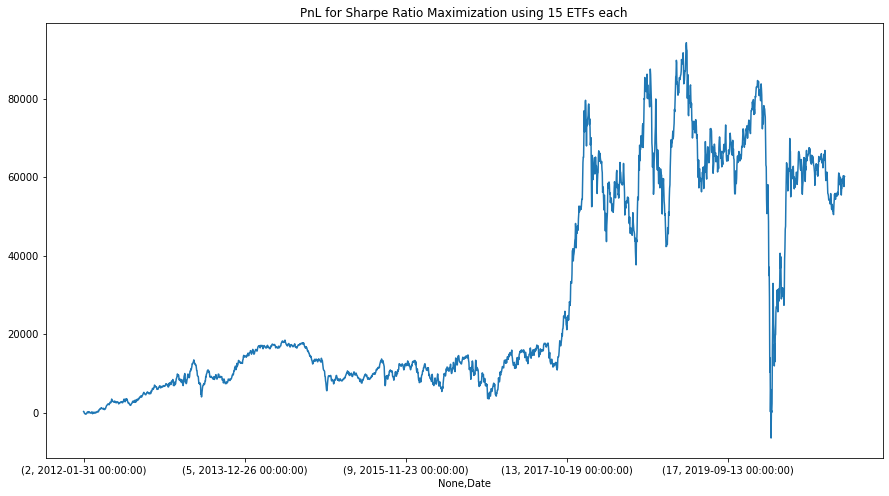

In [64]:
pd.concat(PnL_sr).cumsum().plot(figsize=(15,8))
plt.title('PnL for Sharpe Ratio Maximization using 15 ETFs each')
md = max_drawdown
print(f'Max drawdown: {max_drawdown(pd.concat(PnL_sr).cumsum())}')
overallrisk_sr

Text(0.5, 1.0, 'For Risk parity using 15 ETFs each')

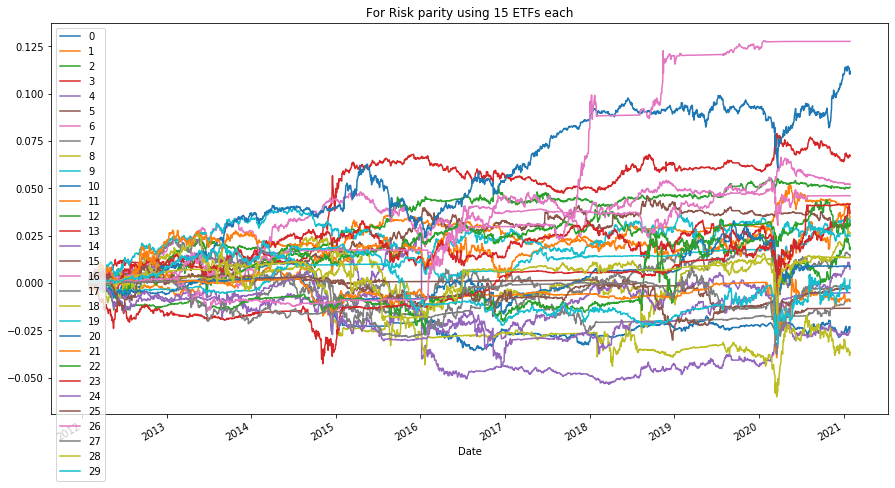

In [65]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.title('For Risk parity using 15 ETFs each')

Text(0.5, 1.0, 'For Sharpe Ratio Maximization using 15 ETFs each')

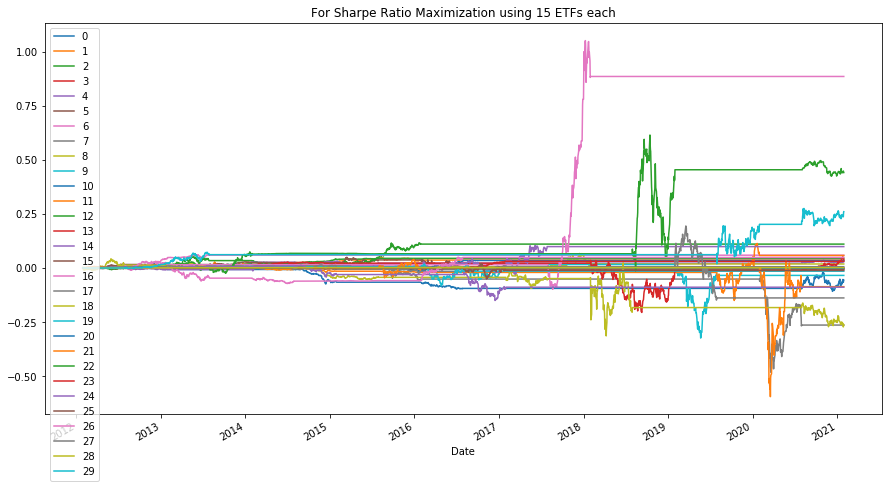

In [66]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.title('For Sharpe Ratio Maximization using 15 ETFs each')

# Optimized weight for cutoff 10-ETFs

In [ ]:
pct_full_portfolio_rp, dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp = portfolio_simulator(100000, semiannual, riskfree, top10, 10, 'Risk parity')
pct_full_portfolio_sr, dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr = portfolio_simulator(100000, semiannual, riskfree, top10, 10, 'Sharpe ratio maximization')

In [ ]:
pd.concat(PnL_rp).cumsum().plot(figsize=(15,8))
plt.title('PnL for Risk parity using 10 ETFs each')
md = max_drawdown
print(f'Max drawdown: {max_drawdown(pd.concat(PnL_rp).cumsum())}')
overallrisk_rp

Max drawdown: -254.94763904365615%


,VaR 95%,VaR 99%,CVaR 95%,CVaR 99%
Period,,,,
2,-326.696992,-433.850041,-383.524500,-471.018262
3,-461.109829,-565.882115,-553.830424,-692.140471
4,-1152.072717,-1830.377898,-1505.926540,-2112.089019
5,-755.571201,-1421.225608,-1107.619301,-1560.063503
6,-502.632513,-698.851747,-609.400214,-769.656623
7,-739.464039,-1371.381570,-1057.404151,-1431.318577
8,-537.316953,-833.001266,-694.869109,-870.477688
9,-1241.780935,-2549.683804,-1846.478946,-2905.026370
10,-1243.704441,-1683.331058,-1509.205724,-1743.318372


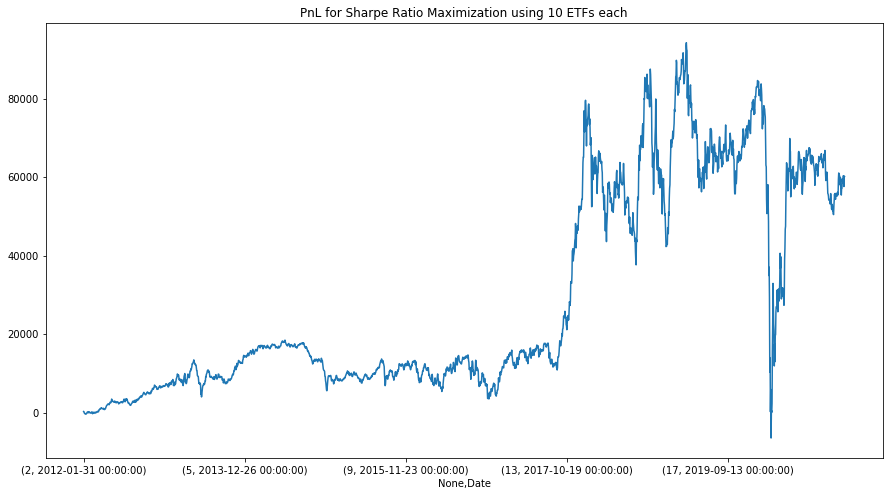

In [67]:
pd.concat(PnL_sr).cumsum().plot(figsize=(15,8))
plt.title('PnL for Sharpe Ratio Maximization using 10 ETFs each')
md = max_drawdown
print(f'Max drawdown: {max_drawdown(pd.concat(PnL_sr).cumsum())}')
overallrisk_sr

Text(0.5, 1.0, 'For Risk parity using 10 ETFs each')

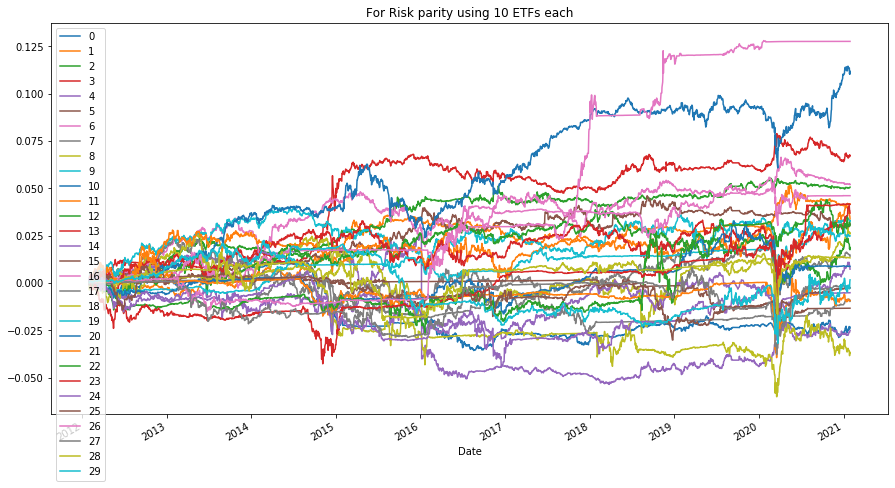

In [68]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.title('For Risk parity using 10 ETFs each')

Text(0.5, 1.0, 'For Sharpe Ratio Maximization using 10 ETFs each')

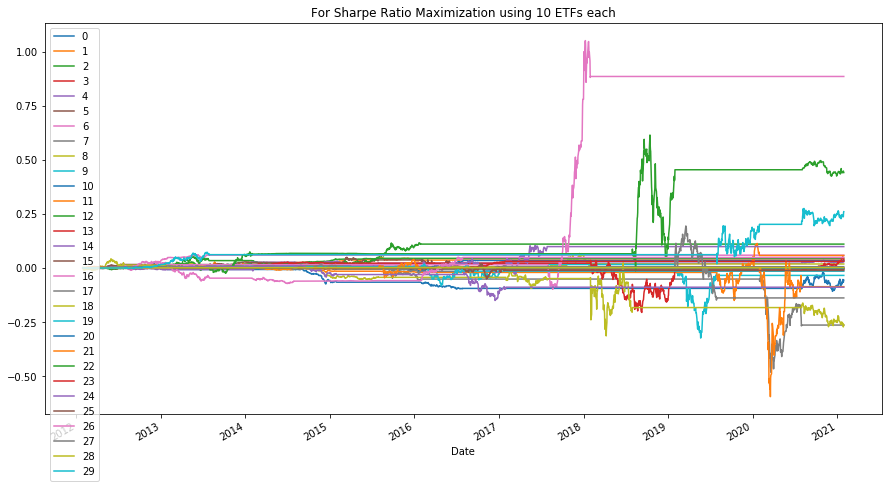

In [69]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.title('For Sharpe Ratio Maximization using 10 ETFs each')